In [11]:
import matplotlib.pyplot as plt
import os
import importlib
import pandas

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from pathlib import Path

# Add parent directory to sys.path
parent_dir = Path("..").resolve()
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
import itertools
from sklearn.metrics import confusion_matrix
import common_utils
importlib.reload(common_utils)
from common_utils import *
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping



In [13]:

image_paths_csv = pd.read_csv("./processed_data/image_paths_7_classes.csv")
#aug data
image_paths_csv_aug = pd.read_csv("./processed_data/image_paths_7_classes_aug.csv")

image_paths_csv = image_paths_csv[image_paths_csv['age'] >= 4]
image_paths_csv_aug = image_paths_csv_aug[image_paths_csv_aug['age'] >= 4]


# bloack for training
train_block_1, val_block_1, train_block_2, val_block_2, test_block=split_blocks(image_paths_csv)

In [14]:
len(train_block_1), len(train_block_2), len(val_block_1), len(val_block_2), len(test_block)

(2779, 2779, 695, 695, 772)

In [15]:
test_block

,path,age,age_bin,age_bin_label,base_name
0,../raw_data2/face_age/004/1063.png,4,0,Infant/Toddler (1–4),1063
1,../raw_data2/face_age/004/1420.png,4,0,Infant/Toddler (1–4),1420
2,../raw_data2/face_age/004/1913.png,4,0,Infant/Toddler (1–4),1913
3,../raw_data2/face_age/004/1989.png,4,0,Infant/Toddler (1–4),1989
4,../raw_data2/face_age/004/2818.png,4,0,Infant/Toddler (1–4),2818
...,...,...,...,...,...
767,../raw_data2/face_age/092/2766.png,92,6,Seniors (75+),2766
768,../raw_data2/face_age/092/7459.png,92,6,Seniors (75+),7459
769,../raw_data2/face_age/093/6681.png,93,6,Seniors (75+),6681
770,../raw_data2/face_age/095/5296.png,95,6,Seniors (75+),5296


In [16]:
train_block_1_aug=add_augmentations(train_block_1)
train_block_2_aug=add_augmentations(train_block_2)

In [17]:
train_block_2_aug.head()

,path,age,age_bin,age_bin_label,base_name
0,../raw_data2/face_age/004/1112_rot20.png,4,0,Infant/Toddler (1–4),1112
0,../raw_data2/face_age/004/1112_rot40.png,4,0,Infant/Toddler (1–4),1112
0,../raw_data2/face_age/004/1112_rot-20.png,4,0,Infant/Toddler (1–4),1112
0,../raw_data2/face_age/004/1112_rot-40.png,4,0,Infant/Toddler (1–4),1112
0,../raw_data2/face_age/004/1112_mirror.png,4,0,Infant/Toddler (1–4),1112


In [18]:
# normal data
batch_size=256
train_block_1_dataset_aug = load_images_from_paths(paths_tensor=tf.constant(list(train_block_1_aug['path'])),batch_size=batch_size,task="autoencoder",resize=192)

train_block_1_dataset_raw = load_images_from_paths(paths_tensor=tf.constant(list(train_block_1['path'])),batch_size=batch_size,task="autoencoder",resize=192)

val_block_1_dataset= load_images_from_paths(paths_tensor=tf.constant(list(val_block_1['path'])),batch_size=batch_size,task="autoencoder",resize=192)

train_block_2_dataset_aug = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_2_aug['path'])),
    target_tensor=tf.constant(list(train_block_2_aug['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)

train_block_2_dataset_raw = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_2['path'])),
    target_tensor=tf.constant(list(train_block_2['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)


val_block_2_dataset= load_images_from_paths(
    paths_tensor=tf.constant(list(val_block_2['path'])),
    target_tensor=tf.constant(list(val_block_2['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)

test_block_dataset_autoencoder=load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    batch_size=batch_size,task="autoencoder",resize=192
)

test_block_dataset = load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    target_tensor=tf.constant(list(test_block['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)



In [8]:

    # {"name": "B2B_deep_bn_7_classes_dense_aug_batch_norm_skip", "conv_filters": [32, 64, 128, 256, 512],"dense_units":[512,256,128], "activation": "relu", "dropout_rate": 0.5, "batch_norm": True,"batch_norm_dense": True,"aug_data":True,"use_skip":True},
configs=[
    {"name": "B2B_deep_bn_reg_aug_autoencoder","epochs":500, "l2_reg": 0,"batch_size":batch_size,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": True, "aug_data": True,
     "task":"autoencoder","resize":192},
]


default_args = {
    "batch_size": 256,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0.5,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    
        cfg_full = {**default_args, **cfg}
        cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
        cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
        
        model = build_autoencoder(
                input_shape=(192, 192, cfg_full["channels"]),
                conv_filters=cfg_full["conv_filters"],
                kernel_size=cfg_full["kernel_size"],
                activation=cfg_full["activation"],
                batch_norm=cfg_full["batch_norm"],
                l2_reg=cfg_full["l2_reg"],
        )
        model.compile(optimizer='adam', loss='mse', metrics=['mse',"accuracy"])
        cfg_full["model"] = model
        
        model_list.append(cfg_full)


In [9]:
config_count=69

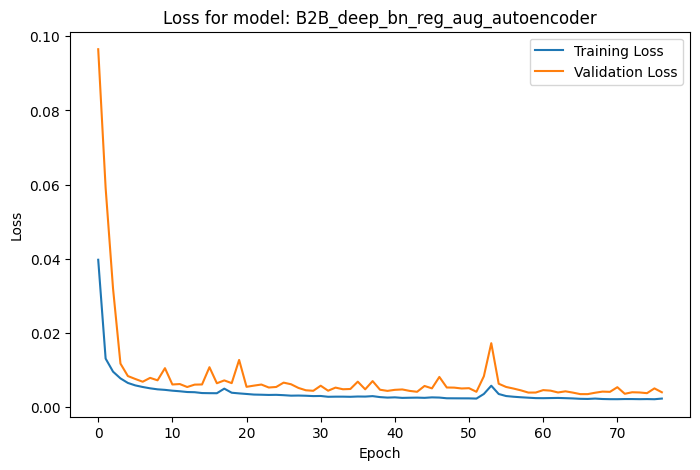

113/113 [==============================] - 17s 146ms/step - loss: 0.0023 - mse: 0.0023 - accuracy: 0.6352 - val_loss: 0.0040 - val_mse: 0.0040 - val_accuracy: 0.9232


In [10]:
os.makedirs(f"autoencoder_saved_models_config_{config_count}",exist_ok=True)
for entry in model_list:
    model_name= entry["name"]
    checkpoint_path = f"autoencoder_saved_models_config_{config_count}/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    callbacks = [checkpoint]


    early_stop_loss = DelayedEarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=60  # begin checks after 60 epochs
    )
    
    callbacks.append(early_stop_loss)
    
    callbacks.append(LiveLossPlot(model_name=model_name))

    history = entry["model"].fit(
        train_block_1_dataset_aug,
        validation_data=val_block_1_dataset,
        epochs=entry["epochs"],
        batch_size=entry["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    entry["history"] = history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"autoencoder_model_summary_config_{config_count}.csv", index=False)


In [19]:
from tensorflow.keras.models import load_model

model=load_model(f"autoencoder_saved_models_config_69/B2B_deep_bn_reg_aug_autoencoder_best_model.keras")

In [20]:
loss = model.evaluate(test_block_dataset_autoencoder)
print(f"Validation loss: {loss}")


4/4 [==============================] - 4s 187ms/step - loss: 0.0034 - mse: 0.0034 - accuracy: 0.9273
Validation loss: [0.003377320012077689, 0.003377320012077689, 0.9273225665092468]


In [21]:
import matplotlib.pyplot as plt

# Get one batch from the dataset
for batch in val_block_1_dataset.take(50):
    x_true = batch[0]  # assuming (x, y) format
    break

# Get reconstructions
x_pred = model.predict(x_true)


8/8 [==============================] - 1s 5ms/step


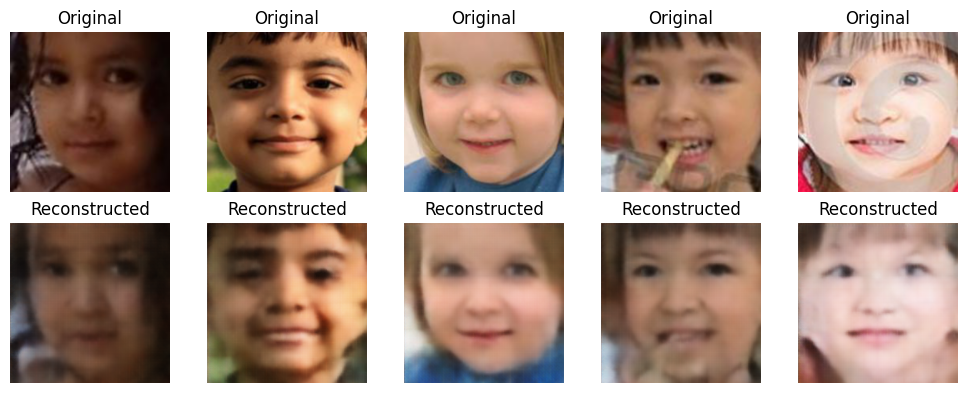

In [22]:
def plot_reconstructions(x_true, x_pred, n=50):
    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(x_true[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(x_pred[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_reconstructions(x_true.numpy(), x_pred, n=5)


In [15]:
def get_image_by_index(dataset, index):
    for i, batch in enumerate(dataset):
        x = batch[0]  # assume (x, y) format
        if index < len(x):
            return x[index]
        index -= len(x)  # subtract batch size and continue
    raise IndexError("Index out of range")


In [16]:
img = get_image_by_index(val_block_1_dataset, 202)  # get 18th image
img = tf.expand_dims(img, axis=0)  # add batch dimension for prediction


1/1 [==============================] - 0s 304ms/step


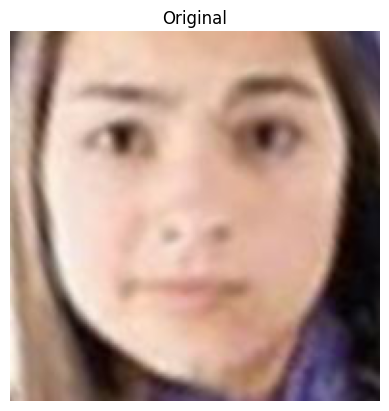

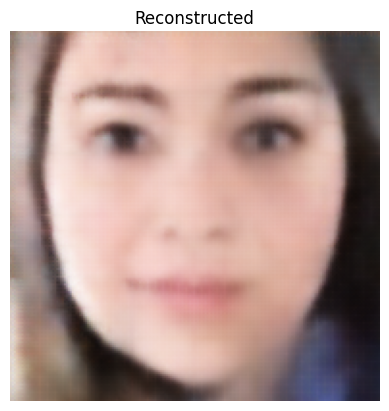

In [17]:
reconstructed = model.predict(img)

plt.imshow(img[0])
plt.title("Original")
plt.axis("off")
plt.show()

plt.imshow(reconstructed[0])
plt.title("Reconstructed")
plt.axis("off")
plt.show()


In [99]:
# Get the encoder up to the 'encoded' layer
encoder_frozen = models.Model(inputs=model.input, outputs=model.get_layer('encoded').output)
encoder_frozen.trainable = False

encoder_non_frozen = models.Model(inputs=model.input, outputs=model.get_layer('encoded').output)
encoder_non_frozen.trainable=True

# encoder = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoded').output)



In [100]:
configs=[
    {"name": "B2B_deep_bn_reg_aug_transfer_frozen","epochs":500, "l2_reg":0,"batch_size":batch_size,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": False, "aug_data": True,
     "task":"classification","resize":192},

    {"name": "B2B_deep_bn_reg_aug_transfer_non_frozen","epochs":500, "l2_reg": 0,"batch_size":batch_size,
    "batch_norm_dense":True, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": False, "aug_data": True,
     "task":"classification","resize":192},
]


default_args = {
    "batch_size": 256,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

ratio=1
# Build all models and store in DataFrame
model_list = []
for cfg in configs:
    cfg_full = {**default_args, **cfg}
    cfg_full["loss"]='categorical_crossentropy' if cfg_full["task"] =="classification" else "mse"
    cfg_full["metrics"]=['accuracy'] if cfg_full["task"] =="classification" else ["mse","mae"]
    
    if "non_frozen" in cfg_full["name"]:
        print("nonfrozen")
        print(cfg_full['name'])
        
        model = models.Sequential([
            encoder_non_frozen,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(7, activation='softmax')  # use 'sigmoid' if multi-label
        ])
        
        # model = build_transfer_model_from_autoencoder(encoder_non_frozen, cfg_full,num_classes=7)
    else:
        print("Frozen")
        print(cfg_full['name'])

        model = models.Sequential([
            encoder_frozen,
            layers.GlobalAveragePooling2D(),
            layers.Dense(512, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(128, activation='relu'),
            # layers.BatchNormalization(),
            # layers.Dropout(0.5),
            layers.Dense(7, activation='softmax')  # use 'sigmoid' if multi-label
        ])

    
        # model = build_transfer_model_from_autoencoder(encoder_frozen, cfg_full,num_classes=7)
        
    model.compile(optimizer='adam', loss=cfg_full["loss"], metrics=cfg_full["metrics"])
    cfg_full["model"] = model
    
    model_list.append(cfg_full)


Frozen
B2B_deep_bn_reg_aug_transfer_frozen
nonfrozen
B2B_deep_bn_reg_aug_transfer_non_frozen


In [22]:
model_list[1]['name']

'B2B_deep_bn_reg_aug_transfer_non_frozen'

In [101]:
model_list[1]['model'].summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_33 (Functional)       (None, 3, 3, 512)         1572544   
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
 1 (GlobalAveragePooling2D)                                      
                                                                 
 dense_145 (Dense)           (None, 512)               262656    
                                                                 
 dense_146 (Dense)           (None, 256)               131328    
                                                                 
 dense_147 (Dense)           (None, 128)               32896     
                                                                 
 dense_148 (Dense)           (None, 7)                 903       
                                                     

config_count=0

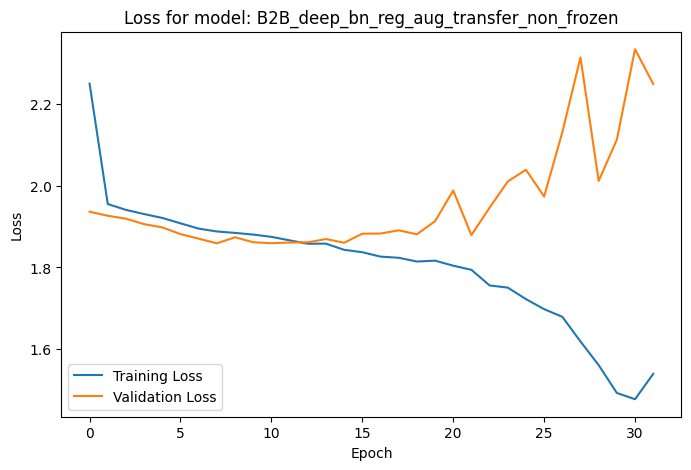

12/12 [==============================] - 1s 121ms/step - loss: 1.5402 - accuracy: 0.3441 - val_loss: 2.2484 - val_accuracy: 0.1986


In [104]:
os.makedirs(f"transfer_saved_models_config_{config_count}",exist_ok=True)
for entry in model_list:
    model_name= entry["name"]
    checkpoint_path = f"transfer_saved_models_config_{config_count}/{model_name}_best_model.keras"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=0
    )

    callbacks = [checkpoint]

    early_stop_loss = DelayedEarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0,
        restore_best_weights=False,
        delay=20  # begin checks after 60 epochs
    )
    
    callbacks.append(early_stop_loss)
    
    callbacks.append(LiveLossPlot(model_name=model_name))

    history = entry["model"].fit(
        train_block_2_dataset_raw,
        validation_data=val_block_2_dataset,
        epochs=entry["epochs"],
        batch_size=entry["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    entry["history"] = history
    entry['best_model_path'] = checkpoint_path
    df_model_summary = pd.DataFrame([
    {k: v for k, v in entry.items() if k not in ['model', 'train_data', 'val_data','test_data']} for entry in model_list])
    df_model_summary.to_csv(f"transfer_model_summary_config_{config_count}.csv", index=False)


In [104]:
model_list[0]['history'].history['loss']

[2.1431968212127686,
 1.937290906906128,
 1.947963833808899,
 1.951267957687378,
 1.928823471069336,
 1.912084937095642,
 1.8914165496826172,
 1.9063103199005127,
 1.9304141998291016,
 1.8994414806365967,
 1.8979605436325073,
 1.895500659942627,
 1.8903402090072632,
 1.856971263885498,
 1.9209920167922974,
 1.9038584232330322,
 1.8974822759628296,
 1.8931634426116943,
 1.8871963024139404,
 1.8864754438400269,
 1.881868600845337,
 1.8836203813552856,
 1.8814493417739868,
 1.8789564371109009,
 1.877853512763977,
 1.8793139457702637,
 1.8780546188354492,
 1.8767350912094116,
 1.8747438192367554,
 1.8794313669204712,
 1.8736937046051025,
 1.8755725622177124,
 1.8749542236328125,
 1.8748842477798462,
 1.8735802173614502,
 1.9169704914093018]

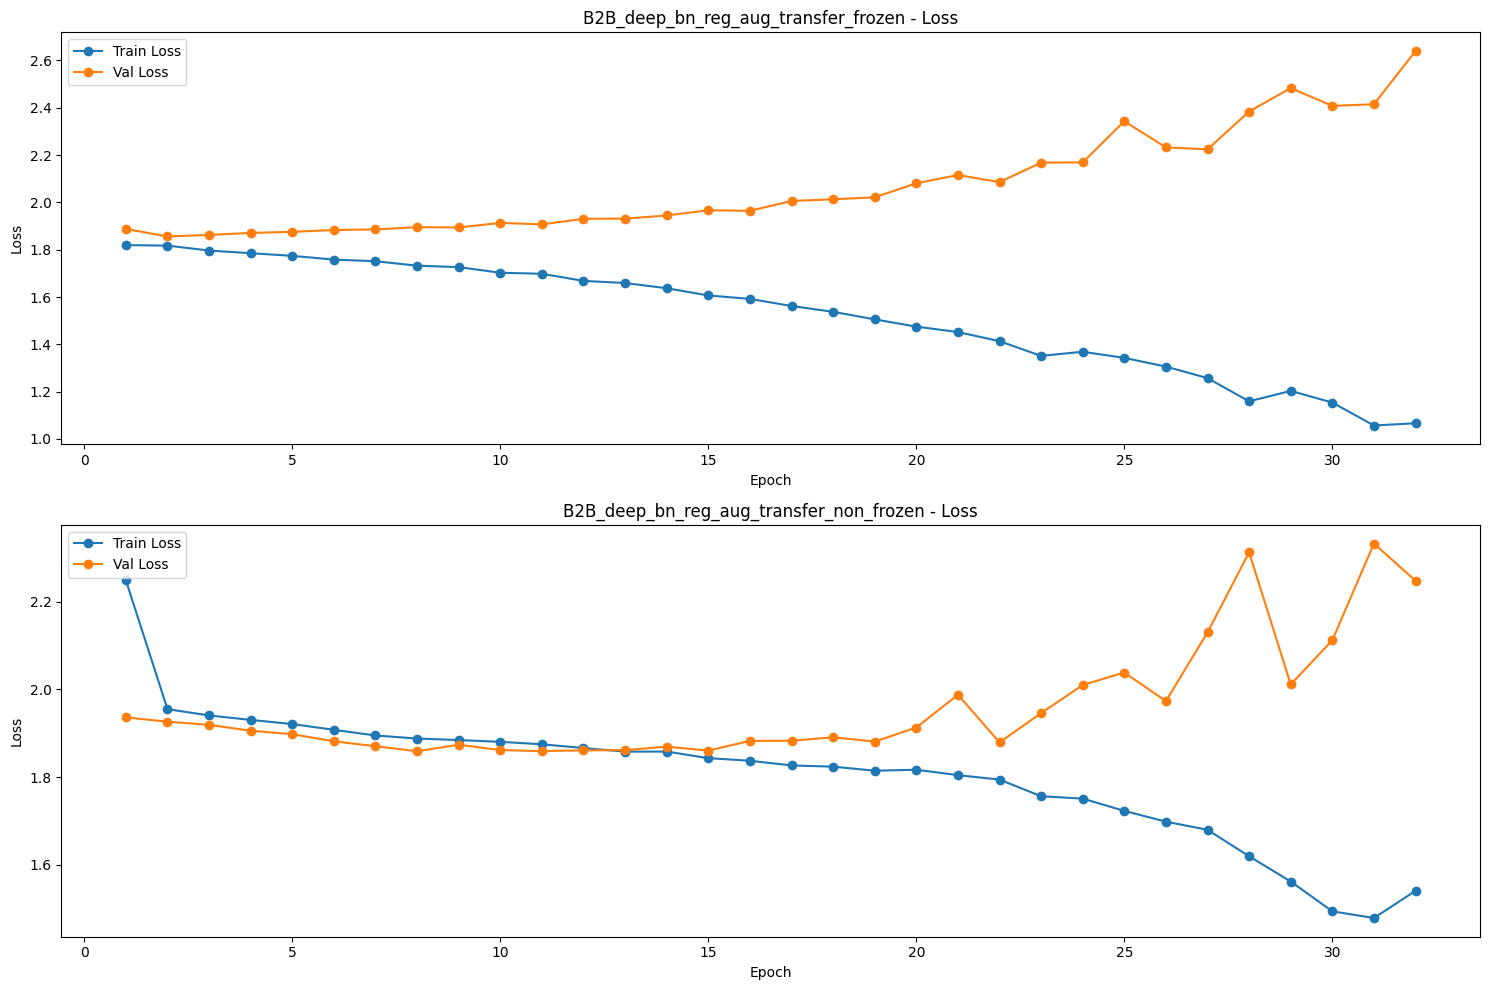

In [105]:
# Create subplots: one row per model, one column (loss only)
fig, axes = plt.subplots(nrows=len(model_list), ncols=1, figsize=(15, 5 * len(model_list)))

# Ensure axes is iterable even if there's only one model
if len(model_list) == 1:
    axes = [axes]

# Loop through each trained model entry
for i, entry in enumerate(model_list):
    try:
        model_name = entry["name"]
        history = entry["history"].history
        epochs = list(range(1, len(history["loss"]) + 1))

        # Loss Plot
        ax_loss = axes[i]
        ax_loss.plot(epochs, history["loss"], label='Train Loss', marker='o')
        ax_loss.plot(epochs, history["val_loss"], label='Val Loss', marker='o')
        ax_loss.set_title(f"{model_name} - Loss")
        ax_loss.set_xlabel("Epoch")
        ax_loss.set_ylabel("Loss")
        ax_loss.legend()
    except Exception:
        continue

plt.tight_layout()
plt.show()


In [43]:


test_block_dataset = load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    target_tensor=tf.constant(list(test_block['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)


# Loop through each trained model entry
for i, entry in enumerate(model_list):
    
        model_name = entry["name"]
        best_model_path = f"transfer_saved_models_config_{config_count}/{model_name}_best_model.keras"
        
        test_dataset = test_block_dataset
        # Load the best saved model
        
        model = load_model(best_model_path)
        

        # Evaluate on test set
        model_score = model.evaluate(test_dataset, verbose=1)
        model_labels = model.metrics_names

        print(f"🔍 {model_name} — Evaluation on Test Set:")
        for label, score in zip(model_labels, model_score):
            print(f"   {label}: {round(score, 4)}")
        print("-" * 40)


    

4/4 [==============================] - 1s 50ms/step - loss: 1.8792 - accuracy: 0.2438
🔍 B2B_deep_bn_reg_aug_transfer_frozen — Evaluation on Test Set:
   loss: 1.8792
   accuracy: 0.2438
----------------------------------------
4/4 [==============================] - 0s 29ms/step - loss: 1.9113 - accuracy: 0.2362
🔍 B2B_deep_bn_reg_aug_transfer_non_frozen — Evaluation on Test Set:
   loss: 1.9113
   accuracy: 0.2362
----------------------------------------


In [36]:
B2B_deep_bn_reg_aug_transfer_frozen - 0.2438

B2B_deep_bn_reg_aug_transfer_non_frozen  - 0.2362

B2B_deep_bn_7_classes_dense_aug_batch_norm_skip - 0.7887

In [44]:


test_block_dataset = load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    target_tensor=tf.constant(list(test_block['age_bin'])),
    batch_size=batch_size,task="classification",resize=200)

model_name="B2B_deep_bn_7_classes_dense_aug_batch_norm_skip"
best_model_path = f"../part_1/saved_models_config_9/B2B_deep_bn_7_classes_dense_aug_batch_norm_skip_best_model.keras"

test_dataset = test_block_dataset
# Load the best saved model

model = load_model(best_model_path)

# Evaluate on test set
model_score = model.evaluate(test_dataset, verbose=1)
model_labels = model.metrics_names

print(f"🔍 {model_name} — Evaluation on Test Set:")
for label, score in zip(model_labels, model_score):
    print(f"   {label}: {round(score, 4)}")
print("-" * 40)
# y_pred = model.predict(test_dataset)
# y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# # Print predicted vs true values
# print("📋 Predictions vs Ground Truth:")
# for pred, true in zip(y_pred.flatten(), y_true.flatten()):
#     print(f"   Predicted: {round(pred, 2)} — Actual: {int(true)}")
# pred_classes = np.argmax(y_pred, axis=1)
# true_classes = np.argmax(y_true, axis=1)

# for pred, true in zip(pred_classes, true_classes):
#     print(f"   Predicted: {pred} — Actual: {true}")


    

4/4 [==============================] - 0s 33ms/step - loss: 0.9103 - accuracy: 0.7887
🔍 B2B_deep_bn_7_classes_dense_aug_batch_norm_skip — Evaluation on Test Set:
   loss: 0.9103
   accuracy: 0.7887
----------------------------------------


In [30]:
configs=[
    {"name": "B2B_deep_bn_reg_aug_transfer_backbone","epochs":500, "l2_reg": 0,"batch_size":256,
    "batch_norm_dense":False, "conv_filters": [32,64,128,256,512],
     "dense_units": [512,256,128], "batch_norm": False, "aug_data": True,
     "task":"classification","resize":192},
]


default_args = {
    "batch_size": 512,
    "epochs": 200,
    "channels": 3,
    "dropout_rate": 0,
    "task": "classification",
    "num_classes": 7,
    "conv_filters": [32, 64, 128],
    "kernel_size": 3,
    "activation": "relu",
    "dense_units": [128],
    "output_activation": "softmax",
    "batch_norm" : False,
    "batch_norm_dense": False,
    "normalize" : True,
    "aug_data": False,
    "use_skip": False,
    "l2_reg":0
    
}

cfg_full={**default_args, **configs[0]}

In [31]:
from tensorflow.keras.applications import MobileNetV2

backbone = MobileNetV2(include_top=False, weights='imagenet', input_shape=(192,192,3))
backbone.trainable = False
model = build_transfer_model_from_autoencoder(backbone, cfg_full,num_classes=7)


model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

cfg_full["model"]=model

In [25]:
train_block_1_dataset_aug = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_1_aug['path'])),
    target_tensor=tf.constant(list(train_block_1_aug['age_bin'])), 
    batch_size=batch_size,
    task="classification",
    resize=192
)
train_block_1_dataset_raw = load_images_from_paths(
    paths_tensor=tf.constant(list(train_block_1['path'])),
    target_tensor=tf.constant(list(train_block_1['age_bin'])), 
    batch_size=batch_size,
    task="classification",
    resize=192
)

val_block_1_dataset= load_images_from_paths(
    paths_tensor=tf.constant(list(val_block_1['path'])),
    target_tensor=tf.constant(list(val_block_1['age_bin'])), 
    batch_size=batch_size,
    task="classification",
    resize=192
)



In [28]:


# Add custom head
model_seq = models.Sequential([
    backbone,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  
])

callbacks=[]
callbacks.append(LiveLossPlot(model_name="seq_model"))

model_seq.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  
    metrics=['accuracy']
)
          

In [ ]:

model_seq.fit(train_block_1_dataset_raw,
    validation_data=val_block_1_dataset, epochs=50,callbacks=callbacks)


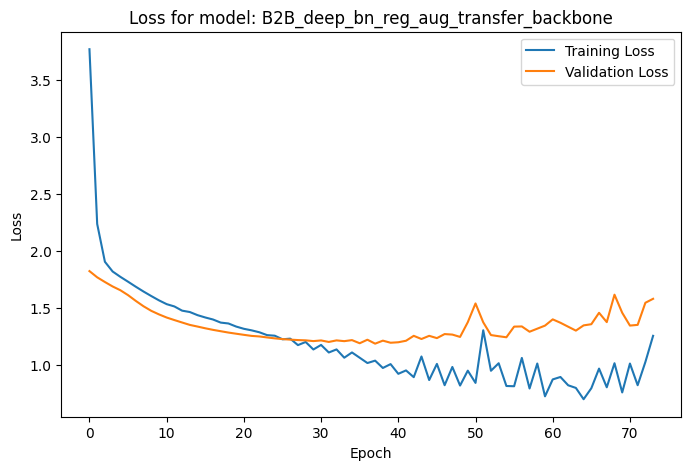

11/11 [==============================] - 1s 104ms/step - loss: 1.2578 - accuracy: 0.5257 - val_loss: 1.5819 - val_accuracy: 0.4403


NameError: name 'model_list' is not defined

In [34]:
config_count=1

os.makedirs(f"backbone_saved_models_config_{config_count}",exist_ok=True)

    
model_name= cfg_full["name"]
checkpoint_path = f"backbone_saved_models_config_{config_count}/{model_name}_best_model.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

callbacks = [checkpoint]

early_stop_loss = DelayedEarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=0,
    restore_best_weights=False,
    delay=60  # begin checks after 60 epochs
)

callbacks.append(early_stop_loss)

callbacks.append(LiveLossPlot(model_name=model_name))

history = cfg_full["model"].fit(
    train_block_1_dataset_raw,
    validation_data=val_block_1_dataset,
    epochs=cfg_full["epochs"],
    batch_size=cfg_full["batch_size"],
    verbose=1,
    callbacks=callbacks
)
cfg_full["history"] = history
cfg_full['best_model_path'] = checkpoint_path

cfg_clean = {k: v if isinstance(v, (str, int, float, bool, list, tuple)) else str(v)
             for k, v in cfg_full.items()}

# Wrap in a list to create a single-row DataFrame
df_model_summary = pd.DataFrame([cfg_clean])

df_model_summary.to_csv(f"backbone_model_summary_config_{config_count}.csv", index=False)


In [42]:

test_block_dataset = load_images_from_paths(
    paths_tensor=tf.constant(list(test_block['path'])),
    target_tensor=tf.constant(list(test_block['age_bin'])),
    batch_size=batch_size,task="classification",resize=192)


In [43]:


model_name = cfg_full["name"]
model = load_model("backbone_saved_models_config_1/B2B_deep_bn_reg_aug_transfer_backbone_best_model.keras")

# Evaluate on test set
model_score = model.evaluate(test_block_dataset, verbose=1)
model_labels = model.metrics_names

print(f"🔍 {model_name} — Evaluation on Test Set:")
for label, score in zip(model_labels, model_score):
    print(f"   {label}: {round(score, 4)}")
print("-" * 40)


    

4/4 [==============================] - 1s 53ms/step - loss: 1.2530 - accuracy: 0.5233
🔍 B2B_deep_bn_reg_aug_transfer_backbone — Evaluation on Test Set:
   loss: 1.253
   accuracy: 0.5233
----------------------------------------
